In [2]:
import os
import gc

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn

from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import wandb

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [12]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

PRE_PATH = '/upstage-cv-classification-cv2/data/'

# PATH
TRAIN_AUG_CSV_PATH = PRE_PATH + 'train_semi_aug2.csv'
TRAIN_AUG_IMAGE_PATH = PRE_PATH + 'train_semi_aug2'

VALID_CSV_PATH = PRE_PATH + 'valid.csv'
VALID_IMAGE_PATH = PRE_PATH + 'valid'

TEST_CSV_PATH = PRE_PATH + 'sample_submission.csv'
TEST_IMAGE_PATH = PRE_PATH + 'test'

RESULT_CSV_PATH = PRE_PATH + 'results/train_semi_aug2.csv'

WANDB_PROJECT_NAME = 'SEMI'
WANDB_RUN_NAME = 'train & test37_agu'

# HyperParameter

In [4]:
# training config
img_size = 380
LR = 1e-3
EPOCHS = 1
BATCH_SIZE = 32
num_workers = 0

patience = 5
min_delta = 0.001 # 성능 개선의 최소 변화량

In [5]:
# test image 변환
data_transform = A.Compose([
    A.Resize(height = img_size, width = img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
    ToTensorV2()
])

class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image = img)['image']
    
        return img, target

    def get_labels(self):
        return self.df[:, 1] 

trn_dataset = ImageDataset(
    TRAIN_AUG_CSV_PATH,
    TRAIN_AUG_IMAGE_PATH,
    transform = data_transform
)

val_dataset = ImageDataset(
    VALID_CSV_PATH,
    VALID_IMAGE_PATH,
    transform = data_transform
)

tst_dataset = ImageDataset(
    TEST_CSV_PATH,
    TEST_IMAGE_PATH,
    transform = data_transform
)

labels = trn_dataset.get_labels()
labels = labels.astype(int)

# DataLoader
trn_loader = DataLoader(
    trn_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = num_workers,
    pin_memory = True,
    drop_last = False
)

val_loader = DataLoader(
    val_dataset,
    batch_size = BATCH_SIZE,
    num_workers = 0,
    pin_memory = True,
    drop_last = False
)

tst_loader = DataLoader(
    tst_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 0,
    pin_memory = True
)

print(len(trn_dataset), len(tst_dataset))

52160 3140


# Model

In [6]:
torch.cuda.empty_cache()
gc.collect()

# model
model = timm.create_model('efficientnet_b4',
                        pretrained=True,
                        num_classes = 17).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b4.ra2_in1k)
INFO:timm.models._hub:[timm/efficientnet_b4.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (classifier.weight, classifier.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


In [7]:
def valid_one_epoch(loader, model, loss_fn, device, epoch):
    model.eval()
    valid_loss = 0

    preds_list =[]
    targets_list = []

    with torch.no_grad():
        pbar = tqdm(loader)
        for step, (image, targets) in enumerate(pbar):
            image = image.to(device)
            targets = targets.to(device)

            preds = model(image)
            loss = loss_fn(preds, targets)
       
            valid_loss += loss.item()
        
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
            targets_list.extend(targets.detach().cpu().numpy())

            pbar.set_description(f"Loss: {loss.item():.4f}")

            wandb.log({
                "valid_step" : epoch * len(loader) + step,
                "valid_loss_step" : loss.item()
            })

    valid_loss /= len(loader)
    valid_acc = accuracy_score(targets_list, preds_list)
    valid_f1 = f1_score(targets_list, preds_list, average = 'macro')

    ret = {
        "epoch" : epoch,
        "valid_loss" : valid_loss,
        "valid_acc" : valid_acc,
        "valid_f1" : valid_f1
    }

    wandb.log({
        "valid_epoch" : epoch,
        "val_loss_epoch" : valid_loss,
        "val_acc" : valid_acc,
        "val_f1" : valid_f1
    })

    return ret

In [8]:
# one epoch 학습
def train_one_epoch(train_loader, model, optimizer, loss_fn, device, epoch):    
    model.train()
    train_loss = 0
    preds_list =[]
    targets_list = []

    pbar = tqdm(train_loader)
    for step, (image, targets) in enumerate(pbar):
        image = image.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

        wandb.log({
            "train_step" : epoch * len(train_loader) + step,
            "train_loss_step" : loss.item()
        })

     
        
    train_loss /= len(train_loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average = 'macro')

    ret = {
        "model" : model,
        "train_epoch" : epoch,
        "train_loss" : train_loss,
        "tarin_acc" : train_acc,
        "train_f1" : train_f1
    }

    wandb.log({
        "train_epoch" : epoch,
        "train_loss_epoch" : train_loss,
        "train_acc" : train_acc,
        "train_f1" : train_f1
    })

    return ret

In [9]:
os.environ['WANDB_SILENT'] = 'true'

f1_scores = []
valid_losses = []
trained_models = []
patience_counter = 0
best_loss = 1

wandb.init(project=WANDB_PROJECT_NAME, name=WANDB_RUN_NAME)

for epoch in range(EPOCHS):
    print(f"{epoch} epoch")
    trn_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device, epoch)
    val_ret =  valid_one_epoch(val_loader, model, loss_fn, device, epoch)

    f1_scores.append(val_ret['valid_f1'])
    valid_losses.append(val_ret['valid_loss'])
    trained_models.append(model)

    print(f"valid loss : {val_ret['valid_loss']}")
    print(f"valid f1 : {val_ret['valid_f1']}")

    # 성능 개선 됨
    if val_ret['valid_loss'] < best_loss - min_delta:
        print(f"성능 개선 됨 : {val_ret['valid_loss']} > {best_loss - min_delta}")
        best_loss = val_ret['valid_loss']
        patience_counter = 0  
        
    # 성능 개선 되지 않음
    else:
        patience_counter += 1  
        print(f"성능 개선 안됨 : {val_ret['valid_loss']} > {best_loss - min_delta}")
        print(f"patience counter : {patience_counter}")

    # 성능 개선이 patience 만큼 안되면 학습 중단
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

0 epoch


Loss: 0.2651: 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]

valid loss : 0.548398444056511
valid f1 : 0.8899152929873339
성능 개선 됨 : 0.548398444056511 > 0.999


# Model Test

In [10]:
best_model_idx = np.argmax(np.array(f1_scores))
best_model = trained_models[best_model_idx]

In [13]:
preds_list = []

best_model.eval()

for image, _ in tqdm(tst_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = best_model(image)
        
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list
pred_df.to_csv(f"{RESULT_CSV_PATH}", index=False)

100%|██████████| 99/99 [00:16<00:00,  6.07it/s]


# 모델 결과 분석

In [14]:
valid_preds_list = []
valid_targets_list = []
valid_probs_list = []

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

model.eval()

with torch.no_grad():
    pbar = tqdm(val_loader)
    for step, (image, targets) in enumerate(pbar):
        image = image.to(device)
        targets = targets.to(device)

        outputs = model(image)
        loss = loss_fn(outputs, targets)

        probs = torch.softmax(outputs, dim=1)
        probs, preds = torch.max(probs, dim=1)
    
        valid_preds_list.extend(preds.detach().cpu().numpy())
        valid_targets_list.extend(targets.detach().cpu().numpy())
        valid_probs_list.extend(probs.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

Loss: 0.2651: 100%|██████████| 10/10 [00:01<00:00,  6.43it/s]


In [15]:
test_preds_list = []
test_probs_list = []
test_preds_second_list = []
test_probs_second_list = []

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

model.eval()

with torch.no_grad():
    pbar = tqdm(tst_loader)
    for step, (image, targets) in enumerate(pbar):
        image = image.to(device)
        targets = targets.to(device)

        outputs = model(image)
        loss = loss_fn(outputs, targets)

        probs = torch.softmax(outputs, dim=1)
        
        # 최댓값과 두 번째로 큰 값 가져오기
        top_probs, top_indices = torch.topk(probs, 2, dim=1)
        
        # 최댓 확률값과 예측 클래스 인덱스
        max_probs = top_probs[:, 0]
        preds = top_indices[:, 0]
        
        # 두 번째로 큰 확률값과 클래스 인덱스
        second_probs = top_probs[:, 1]
        second_preds = top_indices[:, 1]

        # 제일 확률 높은 데이터
        test_preds_list.extend(preds.detach().cpu().numpy()) 
        test_probs_list.extend(max_probs.detach().cpu().numpy())

        # 두번째 확률 높은 데이터  
        test_preds_second_list.extend(second_preds.detach().cpu().numpy())
        test_probs_second_list.extend(second_probs.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")



Loss: 18.7981: 100%|██████████| 99/99 [00:15<00:00,  6.27it/s]


In [16]:
test_result_df = pd.DataFrame()
test_result_df['first_pred'] = test_preds_list
test_result_df['first_prob'] = test_probs_list
test_result_df['second_pred'] = test_preds_second_list
test_result_df['second_prob'] = test_probs_second_list
test_result_df

,first_pred,first_prob,second_pred,second_prob
0,2,0.999999,0,9.297884e-07
1,12,1.000000,6,7.143623e-09
2,5,1.000000,4,4.965795e-11
3,3,0.496328,13,3.344945e-01
4,2,0.999997,11,6.628844e-07
...,...,...,...,...
3135,6,0.999511,7,2.858152e-04
3136,10,1.000000,6,1.215626e-08
3137,8,1.000000,0,1.335091e-11
3138,0,0.999987,13,6.317595e-06


<Axes: xlabel='second_pred', ylabel='first_pred'>

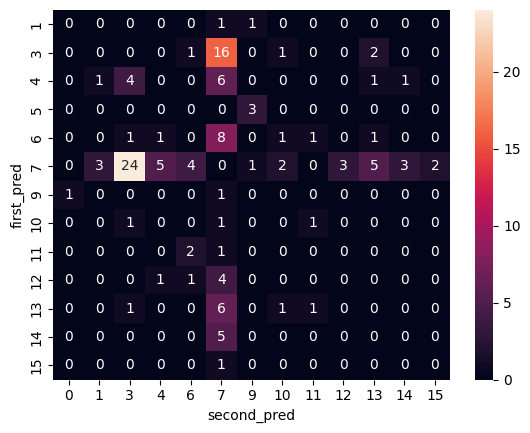

In [18]:
temp_df = test_result_df[(test_result_df['first_prob'] - test_result_df['second_prob']) < 0.3].sort_values(by='first_prob')
crosstab = pd.crosstab(temp_df['first_pred'], temp_df['second_pred'])

sns.heatmap(data = crosstab, annot=True)

In [21]:
print("Classification Report:")
report = classification_report(valid_targets_list, valid_preds_list, target_names=[str(i) for i in range(17)])
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        20
           3       0.55      0.50      0.52        12
           4       0.73      0.94      0.82        17
           5       0.94      1.00      0.97        16
           6       1.00      0.86      0.93        29
           7       0.75      0.60      0.67        20
           8       1.00      0.94      0.97        16
           9       1.00      1.00      1.00        12
          10       0.83      1.00      0.91        20
          11       1.00      0.85      0.92        13
          12       0.96      1.00      0.98        22
          13       1.00      1.00      1.00        17
          14       0.93      0.93      0.93        14
          15       1.00      1.00      1.00        19
          16       0.94      1.00      0.97        16

   